In [1]:
using LinearAlgebra
using Random
using Statistics
using Plots

In [2]:
# Função QR via decomposição de Householder nativa do Julia
function qr_(A)
    F = qr(A)

    Q = Matrix(F.Q)   # matriz Q construída com Householder
    R = F.R           # matriz triangular superior
    return Q, R
end



qr_ (generic function with 1 method)

In [3]:
# Função QR via Gram-Schmidt clássico
function gram_schmidt_qr(A)
    m, n = size(A)
    Q = zeros(Float64, m, n)
    R = zeros(Float64, n, n)

    for j in 1:n
        v = A[:, j]
        for i in 1:j-1
            R[i, j] = Q[:, i]' * A[:, j]
            v -= R[i, j] * Q[:, i]
        end
        R[j, j] = norm(v)
        Q[:, j] = v / R[j, j]
    end
    return Q, R
end

gram_schmidt_qr (generic function with 1 method)

In [4]:
# Função QR via Householder artesanal, seguindo o algoritmo clássico que pode ser aplicado na mão
function householder_qr(A)
    m, n = size(A)
    R = copy(A)  # R vai ser transformada em matriz triangular superior
    Q = Matrix{Float64}(I, m, m)  # Começa como identidade, vai acumulando as reflexões

    for k = 1:min(m - 1, n)
        # 1. Extraímos o vetor da coluna atual a partir da linha k
        x = R[k:end, k]

        # 2. Criamos o vetor v da reflexão de Householder
        e1 = zeros(length(x))
        e1[1] = 1.0
        v = x + sign(x[1]) * norm(x) * e1
        v /= norm(v)

        # 3. Construímos a matriz de reflexão Hk (compacta)
        Hk = Matrix{Float64}(I, m, m)
        Hk[k:end, k:end] .-= 2 * (v * v')   # Atualiza só a submatriz

        # 4. Aplica Hk a R (Hk * R)
        R = Hk * R

        # 5. Acumula a transformação em Q
        Q = Q * Hk
    end

    return Q, R
end


householder_qr (generic function with 1 method)

In [5]:
# Função que executa uma das três versões de QR e imprime os resultados dos erros
function Print_resultados(A, Q, R)
    m, n = size(A)
    
    println("Matriz Q:", Q)
    println("Matriz R:", R)

    # Erro relativo da decomposição (QR ≈ A)
    erro_qr = norm(Q * R - A) / norm(A)

    # Verificação de ortogonalidade (QᵗQ ≈ I)
    erro_ortogonalidade = norm(Matrix(I, m, m) - Q' * Q)

    # Verificação de triangularidade superior de R (parte inferior ≈ 0)
    R_lower = tril(R, -1)  # Pega a parte estritamente inferior
    erro_triangularidade = norm(R_lower) / norm(R)  # Erro relativo

    # Erro de máquina
    ϵ = eps(Float64)

    # Resultados
    println("Erro relativo QR ≈ A:", erro_qr)
    println("Erro de ortogonalidade QᵗQ ≈ I:", erro_ortogonalidade)
    println("Erro de triangularidade R:", erro_triangularidade)
    println("Erro da máquina: ", ϵ)

    println("\nQR é preciso? ", erro_qr < ϵ * 100)
    println("Q é ortogonal? ", erro_ortogonalidade < ϵ * 100)
    println("R é triangular superior? ", erro_triangularidade < ϵ * 100)
    println("\n======================================== \n")
end

Print_resultados (generic function with 1 method)

In [6]:
# Aplicar QR pela função do pacote LinearAlgebra
A=rand(3, 3) # matriz aleatória 3x3
Q, R = qr_(A)
Print_resultados(A,Q,R)

# Aplicar QR via Gram-Schmidt
Qg, Rg = gram_schmidt_qr(A)
Print_resultados(A,Qg,Rg)

# QR Decomposition using Householder reflections
Qh, Rh = householder_qr(A)
Print_resultados(A,Qh,Rh)

Matriz Q:[-0.7468247299972899 0.27903748083469687 -0.603647999213036; -0.26756387188518366 -0.9570803119790947 -0.1113860443853164; -0.6088204966377893 0.07832854340165414 0.7894315943527285]
Matriz R:[-1.212127705019208 -0.747088978663413 -0.7634477400883506; 0.0 -0.7167452356785466 -0.052016039242639645; 0.0 0.0 -0.36555840224732683]
Erro relativo QR ≈ A:2.2591634081793994e-16
Erro de ortogonalidade QᵗQ ≈ I:3.466670283279959e-16
Erro de triangularidade R:0.0
Erro da máquina: 2.220446049250313e-16

QR é preciso? true
Q é ortogonal? true
R é triangular superior? true


Matriz Q:[0.7468247299972898 -0.2790374808346969 0.6036479992130358; 0.26756387188518366 0.9570803119790947 0.11138604438531644; 0.6088204966377893 -0.07832854340165413 -0.7894315943527287]
Matriz R:[1.212127705019208 0.7470889786634128 0.7634477400883505; 0.0 0.7167452356785466 0.05201603924263962; 0.0 0.0 0.3655584022473268]
Erro relativo QR ≈ A:0.0
Erro de ortogonalidade QᵗQ ≈ I:3.2084412964475094e-16
Erro de triangul

In [7]:
# Função para gerar uma matriz de tamanho m x m com número de condição desejado usando SVD
function generate_any_conditioned_matrix(m, desired_condition_number)
    # Gera duas matrizes ortogonais U e V a partir de QR de matrizes aleatórias
    U, _ = qr(randn(m, m))
    V, _ = qr(randn(m, m))

    # Cria os valores singulares de forma decrescente, de 1 até 1/desired_condition_number
    # Usamos uma escala logarítmica para distribuir os valores singulares
    singular_values = exp.(range(0, -log(desired_condition_number), length=m))
    D = Diagonal(singular_values)

    # Monta a matriz mal condicionada: A = U * D * Vᵀ 
    A = U * D * V'

    return A
end

# Função para testar sensibilidade
function plot_sensitivity(cond_good, cond_bad; N=50)
    n = 10
    A_good = generate_any_conditioned_matrix(n, cond_good)
    A_bad = generate_any_conditioned_matrix(n, cond_bad)

    x_real = ones(n)
    b_good = A_good * x_real
    b_bad = A_bad * x_real

    epsilons = range(1e-10, 0.10, length=100)
    errors_good = Float64[]
    errors_bad = Float64[]

    for eps in epsilons
        temp_errors_good = []
        temp_errors_bad = []

        for _ in 1:N
            δb = eps * randn(n)

            x_good = A_good \ (b_good + δb)
            x_bad = A_bad \ (b_bad + δb)

            push!(temp_errors_good, norm(x_good - x_real) / norm(x_real))
            push!(temp_errors_bad, norm(x_bad - x_real) / norm(x_real))
        end

        push!(errors_good, mean(temp_errors_good))
        push!(errors_bad, mean(temp_errors_bad))
    end

    plot(epsilons, errors_good, label="Bem Condicionado", lw=2, color=:blue, yscale=:log10)
    plot!(epsilons, errors_bad, label="Mal Condicionado", lw=2, ls=:dash, color=:red)

    xlabel!("Magnitude da Perturbação na Entrada (ε)")
    ylabel!("Erro na Saída (Δx)")
    title!("Sensibilidade a Perturbações na Entrada")
end




plot_sensitivity (generic function with 1 method)

In [8]:
# Testando a função de plotagem com uma matriz 7x7 e número de condição 1 ate 10^10
for k in 10 .^(0:10) 
    A = generate_any_conditioned_matrix(7, k)
    println("Número condicional: ", cond(A))
end    
    


Número condicional: 1.0000000000000013
Número condicional: 10.000000000000012
Número condicional: 99.9999999999999
Número condicional: 1000.0000000000039
Número condicional: 10000.000000000491
Número condicional: 99999.9999996348
Número condicional: 999999.9999927399
Número condicional: 1.0000000003654763e7
Número condicional: 9.999999970698993e7
Número condicional: 1.0000000294988315e9
Número condicional: 1.0000000252120338e10


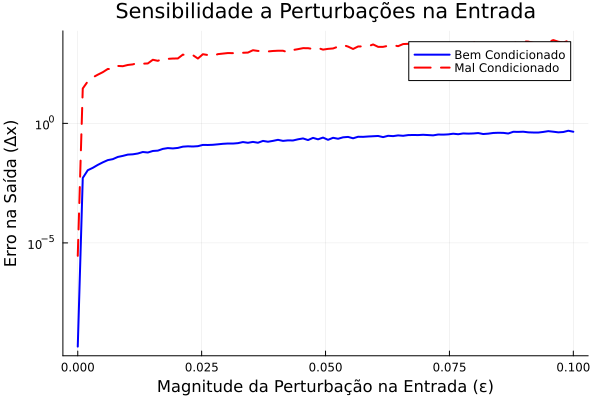

In [9]:
# Gerar o gráfico
plot_sensitivity(10, 1e5)

In [10]:
# Função para registrar erros de QR em vetores globais (Print_resultados em larga escala)
function registrar_erros_qr(A, Q, R, id_alg, c)
    m, n = size(A)

    # Erro relativo da decomposição (QR ≈ A)
    erro_qr = norm(Q * R - A) / norm(A)

    # Verificação de ortogonalidade (QᵗQ ≈ I)
    erro_ortogonalidade = norm(Matrix(I, m, m) - Q' * Q)

    # Verificação de triangularidade superior de R (parte inferior ≈ 0)
    R_lower = tril(R, -1)  # Pega a parte estritamente inferior
    erro_triangularidade = norm(R_lower) / norm(R)  # Erro relativo

    # Erro de máquina
    ϵ = eps(Float64)

    # Atualiza vetores globais
    global qr_errors[id_alg] += erro_qr > ϵ * c
    global q_ortho_errors[id_alg] += erro_ortogonalidade > ϵ * c
    global r_triang_errors[id_alg] += erro_triangularidade > ϵ * c
end


# Função para plotar os erros das 3 implementacões de QR simulando N execuções com uma matriz de condição específica 
function plot_error(N, m, k, c)
    # Vetores globais de contagem
    global qr_errors = [0, 0, 0]
    global q_ortho_errors = [0, 0, 0]
    global r_triang_errors = [0, 0, 0] 

    # Loop de N execuções para cada método
    for i in 1:N
        A = generate_any_conditioned_matrix(m, k)

        # Método 1: QR de Julia (Householder interno)
        Q1, R1 = qr_(A)
        registrar_erros_qr(A, Q1, R1, 1, c)

        # Método 2: Gram-Schmidt
        Q2, R2 = gram_schmidt_qr(A)
        registrar_erros_qr(A, Q2, R2, 2, c)

        # Método 3: Householder implementado manualmente
        Q3, R3 = householder_qr(A)
        registrar_erros_qr(A, Q3, R3, 3, c)
    end

    # Função para formatar a saída com contagem e porcentagem
    function format_error(count)
        percentage = round(count / N * 100, digits=2)
        return "$count ($percentage%)"
    end

    # Exibe os resultados após as execuções
    println("Erros QR (decomposição ≠ A) em $N execuções:")
    println("QR padrão:        ", format_error(qr_errors[1]))
    println("Gram-Schmidt:     ", format_error(qr_errors[2]))
    println("Householder:      ", format_error(qr_errors[3]))

    println("\nErros de ortogonalidade (QᵗQ ≠ I) em $N execuções:")
    println("QR padrão:        ", format_error(q_ortho_errors[1]))
    println("Gram-Schmidt:     ", format_error(q_ortho_errors[2]))
    println("Householder:      ", format_error(q_ortho_errors[3]))

    println("Erros de triangularidade (R não é triangular) em $N execuções:")
    println("QR padrão:        ", format_error(r_triang_errors[1]))
    println("Gram-Schmidt:     ", format_error(r_triang_errors[2]))
    println("Householder:      ", format_error(r_triang_errors[3]))

    # Plotando os gráficos dos erros

    # Erros de decomposição (QR ≠ A)
    bar1 = bar([qr_errors[1], qr_errors[2], qr_errors[3]], label=["QR padrão", "Gram-Schmidt", "Householder"], title="Erros QR (decomposição ≠ A)", ylabel="Erro", xlabel="Métodos")

    # Erros de ortogonalidade (QᵗQ ≠ I)
    bar2 = bar([q_ortho_errors[1], q_ortho_errors[2], q_ortho_errors[3]], label=["QR padrão", "Gram-Schmidt", "Householder"], title="Erros de Ortogonalidade (QᵗQ ≠ I)", ylabel="Erro", xlabel="Métodos")

    # Erros de triangularidade (R não é triangular)
    bar3 = bar([r_triang_errors[1], r_triang_errors[2], r_triang_errors[3]], label=["QR padrão", "Gram-Schmidt", "Householder"], title="Erros de Triangularidade (R não é triangular)", ylabel="Erro", xlabel="Métodos")

    # Exibe os gráficos
    plot(bar1, bar2, bar3, layout=(3, 1), size=(1200, 900))
end

plot_error (generic function with 1 method)

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     22182 (22.18%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)


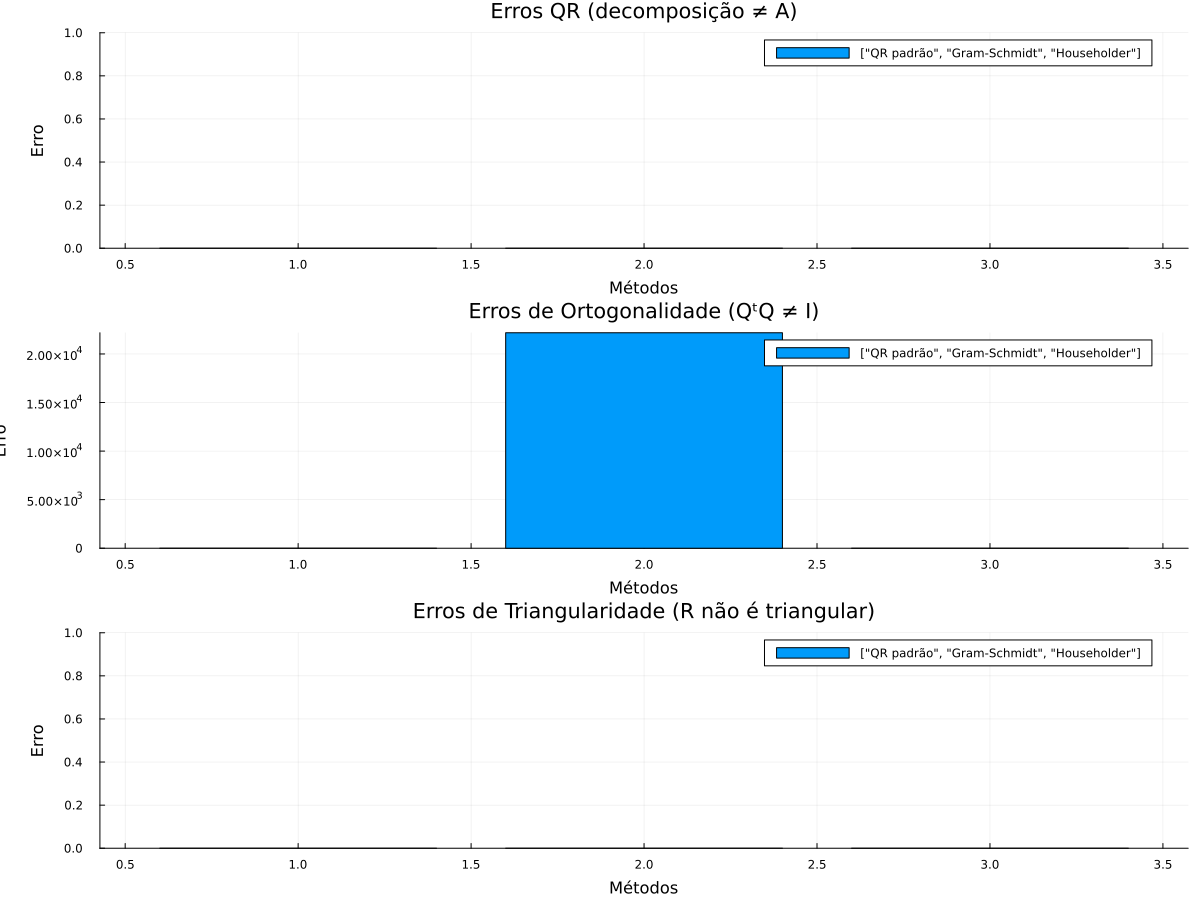

In [11]:
# Executando a função de plotagem com 100000 execuções, matriz 3x3 e número de condição 100(bem condicionada)
plot_error(100000, 3, 100, 100)

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     58366 (58.37%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)


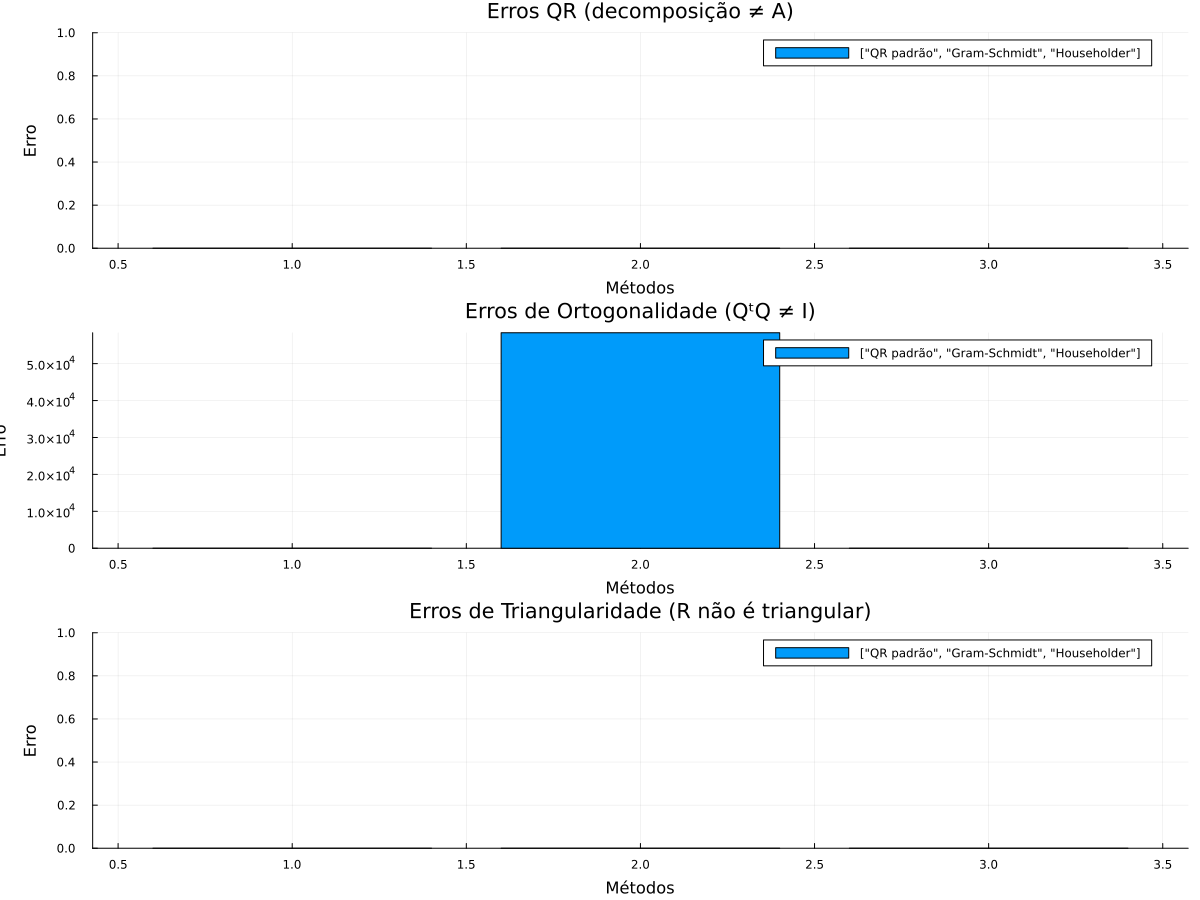

In [12]:
plot_error(100000, 5, 100, 100)


In [13]:
# Função para analisar o erro de ortogonalidade em diferentes dimensões
function analyze_orthogonality_error(N, max_dim, k, c)
    dims = 2:max_dim
    n = length(dims)

    errors_qr = zeros(n)
    errors_gs = zeros(n)
    errors_hh = zeros(n)
    
    for (i, d) in enumerate(dims)
        global q_ortho_errors = [0, 0, 0]
        
        plot_error(N, d, k, c)
        
        errors_qr[i] = q_ortho_errors[1] / N * 100
        errors_gs[i] = q_ortho_errors[2] / N * 100
        errors_hh[i] = q_ortho_errors[3] / N * 100
        
        println("Dimensão $d concluída")
    end
    
    p = plot(dims, hcat(errors_qr, errors_gs, errors_hh), 
             label=["QR Padrão" "Gram-Schmidt" "Householder"],
             xlabel="Dimensão da Matriz", 
             ylabel="Porcentagem de Erro de Ortogonalidade (%)",
             title="Evolução do Erro de Ortogonalidade por Dimensão\ncom c = $(c) e cond(A) = $(k)",
             linewidth=2,
             markershape=:circle,
             markersize=4,
             legend=:topleft)
    
    display(p)
end



analyze_orthogonality_error (generic function with 1 method)

## Sobre o parâmetro c

O parâmetro c funciona como um fator de tolerância para determinar se um erro numérico é significativo ou não. Em vez de comparar diretamente os erros com o erro de máquina (ϵ), usamos c * ϵ como limite. Isso permite controlar a sensibilidade da detecção de erros: valores pequenos de c tornam o critério mais rigoroso (detecta até erros muito pequenos), enquanto valores maiores de c tornam o critério mais permissivo, considerando aceitáveis erros maiores. Na prática, esse fator é necessário porque, em cálculos numéricos com várias operações acumuladas (como nas decomposições QR), o erro total pode ser naturalmente algumas dezenas ou centenas de vezes maior que o ϵ da máquina, sem que isso represente um problema real de estabilidade.

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     783 (0.78%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 2 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        7 (0.01%)
Gram-Schmidt:     2383 (2.38%)
Householder:      12 (0.01%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 3 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:   

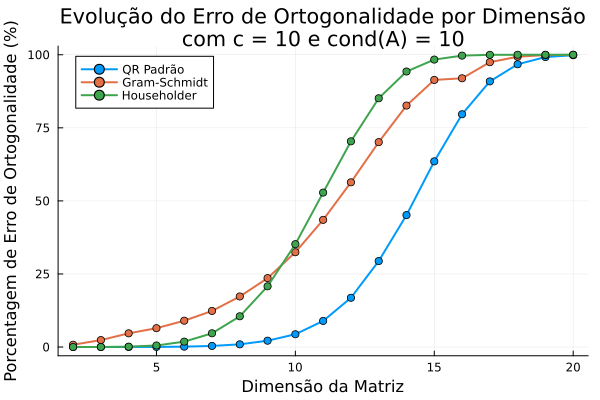

In [14]:
#testando a função de análise de erro de ortogonalidade com matrizes muito bem condicionadas e c = 10 para evidenciar os erros
analyze_orthogonality_error(100000, 20, 10, 10)

A partir daqui adotamos o valor padrão 100 * ϵ porque, na prática, os erros de arredondamento que surgem em algoritmos numéricos não se acumulam de forma isolada, mas sim ao longo de múltiplas operações (somas, multiplicações, transformações, etc.). Cada operação introduz um erro proporcional ao ϵ da máquina, e quando o algoritmo envolve dezenas ou centenas de operações (como na decomposição QR), é comum que o erro total se aproxime de 10 a 100 vezes o erro de máquina.

O valor 100 * ϵ é um compromisso que não é tão rigoroso a ponto de acusar falsamente erros naturais da aritmética de ponto flutuante, e não é tão liberal a ponto de ignorar erros realmente significativos que indiquem perda de estabilidade ou precisão.

Se adotássemos apenas ϵ como limiar, quase todo algoritmo que faça mais do que pouquíssimas operações já pareceria "impreciso" — o que seria uma falsa avaliação da estabilidade.

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 2 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 3 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%

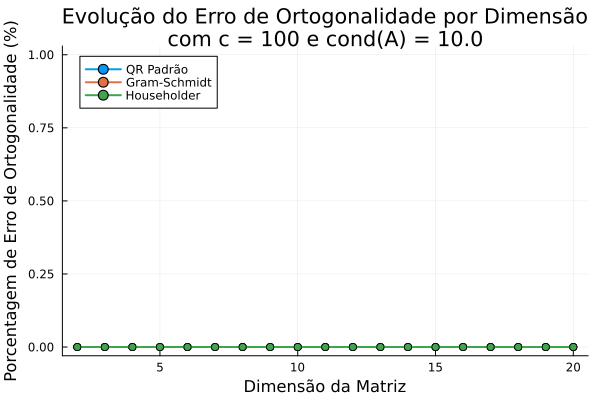

In [15]:
#testando a função de análise de erro de ortogonalidade com matrizes bem condicionadas e c ajustado para 100
analyze_orthogonality_error(100000, 20, 1e1, 100)

Neste primeiro teste com matrizes muito bem condicionadas (k=10), percebemos que o erro de ortogonalidade permanece "nulo" para todos os algoritimos em todas dimensões

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     795 (0.8%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 2 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     21962 (21.96%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 3 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:     

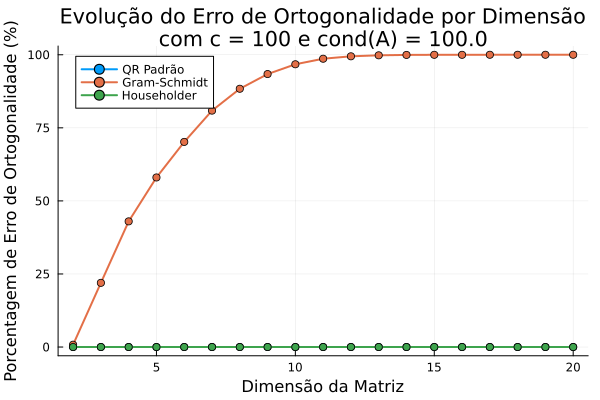

In [16]:
#testando a função de análise de erro de ortogonalidade com matrizes menos bem condicionadas 
analyze_orthogonality_error(100000, 20, 1e2, 100)

Neste segundo teste com matrizes bem condicionadas (k=100), percebemos que o erro de ortogonalidade permanece "nulo" apenas para os householders em todas dimensões, e é gradualmente crescente para o gram-Schmidt, que não é estável.

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     63165 (63.17%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 2 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     92630 (92.63%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 3 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder: 

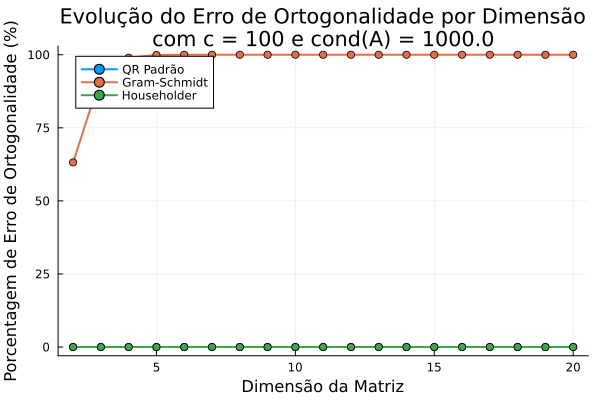

In [17]:
#testando a função de análise de erro de ortogonalidade com matrizes mau condicionadas 
analyze_orthogonality_error(100000, 20, 1e3, 100)

Neste teste com matrizes mal condicionadas (k=1000), percebemos resultado semelhante ao anterior, com um agravante no erro do Gram-Schmidt, que se estaguina perto do 100% muito mais cedo, já tendo um erro elevado mesmo em dimensões menores.

Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     100000 (100.0%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 2 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)

Erros de ortogonalidade (QᵗQ ≠ I) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     100000 (100.0%)
Householder:      0 (0.0%)
Erros de triangularidade (R não é triangular) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder:      0 (0.0%)
Dimensão 3 concluída
Erros QR (decomposição ≠ A) em 100000 execuções:
QR padrão:        0 (0.0%)
Gram-Schmidt:     0 (0.0%)
Householder

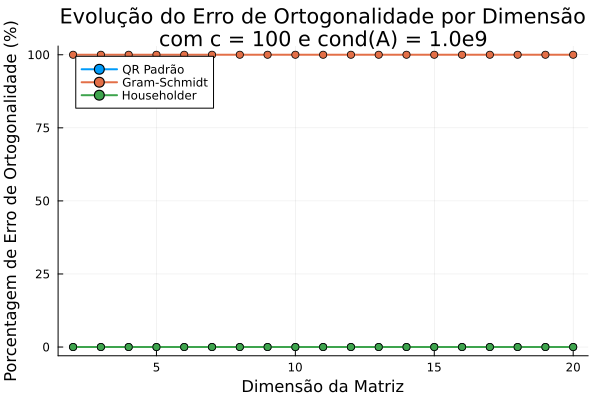

In [18]:
#testando a função de análise de erro de ortogonalidade com matrizes péssimamente condicionadas
analyze_orthogonality_error(100000, 20, 1e9, 100)

Neste último teste com matrizes péssimamente condicionadas (k=10^9), temos o resultado com mais destaque da diferença ente um algoritimo não estável e um backward stable. Gram-Schmidt desde a dimensão 2 ja apresenta praticamente 100% de erro nas 100000 execuções. E mesmo com matrizes tão mau condicionadas, os householders (nativo do julia e o implementado por nós), continuam mostrando erro mínimo. 

Assim confirmando a potência da estabilidade do householder.